# Example for running a 2-stage alignment

## Package Installations
As a first step, you should clone this repository in your system by running the following:
<br>
```git clone https://github.com/donglaiw/ExM-Toolbox.git```
<br>
Then, we would like to switch to the branch containing the **mExR** directory. 
<br>
```
cd ExM-Toolbox
git checkout ck
```
Now, install the required packages as described in the README file. Make sure that before running the code, you have activated the correct ```conda``` environment and have activated it. 

## Configurations
An important (and perhaps the most critical part) of any scientific experiment is reproducibility. If instructions are not robust and explicit, one cannot justify their claims of discovering something that is real. 
<br>
In the cases pertaining to computation, this problem usually boils down to parameters. To prevent (or minimize) problems such as overwriting, we define a global configuration file that encapsulates all parameters (which can be found in ```configs/default.py```).

In [1]:
from config.utils import load_cfg
import json

# load configuration file
cfg = load_cfg()

pretty_cfg = json.dumps(cfg, indent=4)

print(pretty_cfg)

{
    "SYSTEM": {},
    "FILTER": {
        "FILTER_STRENGTH": 70,
        "THRESH_LOWER": 60,
        "THRESH_UPPER": 255,
        "MASK_INDEX": 6,
        "DELTA": 230,
        "DENOISE": false,
        "MASK": false
    },
    "INTENSITY": {
        "RESOLUTION": [
            0.1625,
            0.1625,
            0.25
        ],
        "TRANSFORM_TYPE": [
            "affine"
        ],
        "NumberOfSamplesForExactGradient": [
            "100000"
        ],
        "MaximumNumberOfIterations": [
            "10000"
        ],
        "MaximumNumberOfSamplingAttempts": [
            "15"
        ],
        "FinalBSplineInterpolationOrder": [
            "1"
        ]
    },
    "POINT": {
        "NUM_POINTS": 20,
        "MAX_ITER": 1500,
        "CHANNEL": 2,
        "NN_DIST": 6,
        "FILTER_STRENGTH_FIX": 50,
        "FILTER_STRENGTH_MOVE": 80,
        "THRESH_LOWER_FIX": 70,
        "THRESH_LOWER_MOVE": 50,
        "TARGET_CHANNEL": 1
    },
    "DATASET": {
       


That's a lot of parameters! However, there are just a few which need to be tweaked and the alignment works just as well with the defaults as I describe below.
<br>
Note that the configuration file is **immutable** by nature. To make changes to the configuration, we would need to make it mutable.

In [2]:
# make configuration mutable
cfg.defrost()

## Filter
Let us begin by seeing the first set of parameters specified for **coarse alignemtnt** (under *filter*) and their effect on the images. The set of parameters defined here are used to create binarized images which is (largely) free from signal noise.
<br>
We consider two examples to explain this.

In [3]:
from tiffile import imread 

im1 = imread('/mp/nas3/Margaret_mouse_new/2022.08_synapses/ROI2_round001_pp.tif')

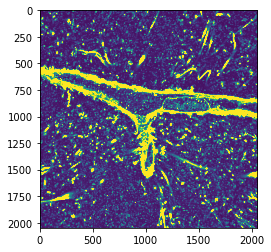

In [4]:
# take channel-4 as the reference
im1_c4 = im1[:,3]
# choose a single Z-slice
im1_slice = im1_c4[35, :, :,]

import matplotlib.pyplot as plt
plt.imshow(im1_slice, vmax=600)


Here, we can see that a single $Z$-slice from the said image volume has a lot of signal noise that reduces the quality of alignment. To mask out the noise and obtain a cleaner image, we can threshold (```cfg.FILTER.THRESH_LOWER```) the image and apply a denoising filter (```cfg.FILTER.FILTER_STRENGTH```). 

The code cells below can be used to determine the value of the parameters for different volumes as well.

In [5]:
import cv2 as cv

# denoising the image
denoised = cv.fastNlMeansDenoising(im1_slice.astype('uint8'), h=160, templateWindowSize=7, searchWindowSize=21)

# thresholding the image
(T, threshInv) = cv.threshold(denoised, thresh=50, maxval=255,
                                   type=cv.THRESH_BINARY_INV)
threshInv = 255 - threshInv

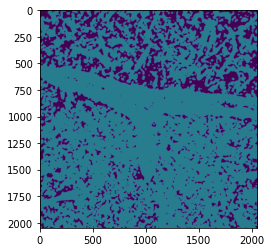

In [6]:
plt.imshow(threshInv, vmax=600)


Oops! The thresholding seen above is pretty bad. This is because the lower bound of the threshold is low, due to which large parts of the background have been falsely *segmented* as being part of the coarse structure. 

Suppose that we take lower bound which is on the higher side.

In [7]:
# denoising the image
denoised = cv.fastNlMeansDenoising(im1_slice.astype('uint8'), h=160, templateWindowSize=7, searchWindowSize=21)

# thresholding the image
(T, threshInv) = cv.threshold(denoised, thresh=150, maxval=255,
                                   type=cv.THRESH_BINARY_INV)
threshInv = 255 - threshInv

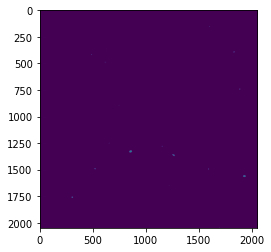

In [8]:
plt.imshow(threshInv, vmax=600)


We have some minor puncta in this case, but not what we would like to see. There is no *algorithm* per se to choose the correct thresholding values - it is purely based on hit and trial and visual correctness. 

Let us try something midway between the values that we used above.

In [9]:
# denoising the image
denoised = cv.fastNlMeansDenoising(im1_slice.astype('uint8'), h=160, templateWindowSize=7, searchWindowSize=21)

# thresholding the image
(T, threshInv) = cv.threshold(denoised, thresh=120, maxval=255,
                                   type=cv.THRESH_BINARY_INV)
threshInv = 255 - threshInv

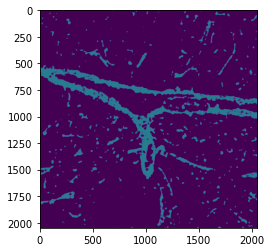

In [10]:
plt.imshow(threshInv, vmax=600)


That is much better! Even still, we see that the boundaries of the coarse structure are somewhat *"thin"*. This has happened due to a slightly large value of the denoising filter. The effect of reducing it whilst keeping the same threshold value can be seen below.

In [11]:
# denoising the image
denoised = cv.fastNlMeansDenoising(im1_slice.astype('uint8'), h=100, templateWindowSize=7, searchWindowSize=21)

# thresholding the image
(T, threshInv) = cv.threshold(denoised, thresh=120, maxval=255,
                                   type=cv.THRESH_BINARY_INV)
threshInv = 255 - threshInv

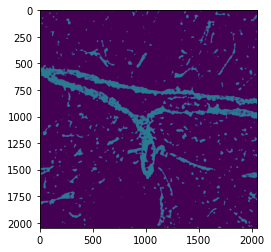

In [12]:
plt.imshow(threshInv, vmax=600)


A very subtle difference is seen here in comparison to the previous result. We could perhaps still do better, but lets leave it at this for now.

Since our interest is to capture only the coarse structures for the initial part of the pipeline, we want to mask out the smaller segments in the above image. In a nutshell, we would like to mask everything other than say the $l$ largest objects. This is incorporated in ```cfg.FILTER.MASK_INDEX```. 

The function in the code cell below is a boilerplate for the actual implementation. It helps us determine an appropriate choice for $l$.

In [13]:
import numpy as np
from skimage.measure import label

def filter_image(img: np.ndarray, min_idx: int):
    assert min_idx > 1, "minimum area index must be greater than 1"
    
    upper_bound_idx = []
    lower_bound_idx = []
    
    labeled_img = label(img, background=0)
    indices, area = np.unique(labeled_img, return_counts=True)
    sorted_area = sorted(area)
    
    # indices of high area regions
    for i in range(len(area)):
        for j in range(2, min_idx):
            if (area[i] == sorted_area[len(area) - j]):
                upper_bound_idx.append(i)
    
    for i in range(len(area)):
        lower_bound_idx.append(i)
    
    # indices of low area regions (noise)
    for idx in upper_bound_idx:
        try:
            lower_bound_idx.remove(idx)
        except:
            print(f'{idx} not present')
    
    # mask out noise
    for idx in lower_bound_idx:
        labeled_img[np.where(labeled_img==idx)] = 0
        
    return labeled_img

In [14]:
img = filter_image(threshInv, min_idx=4)

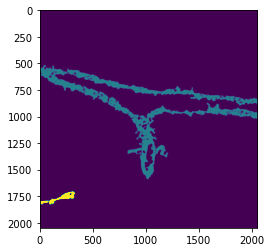

In [15]:
plt.imshow(img, vmax=600)


This might have masked out one too many anchor structures needed for coarse alignment. We try a slightly higher value ($=30$) for ```min_idx```, which is the same as what we introduced to be $l$.

In [16]:
img = filter_image(threshInv, min_idx=30)

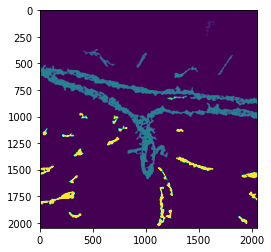

In [17]:
plt.imshow(img, vmax=600)


Not bad! This looks about right where none of the major structures have been masked. Using this, we can go ahead and set the configuration parameters.

In [18]:
cfg.FILTER.FILTER_STRENGTH = 100
cfg.FILTER.THRESH_LOWER = 120
cfg.FILTER.MASK_INDEX = 30


In many cases, the coarse alignment works just fine without the masking as well as thresholding + denoising step or any combination of the two. The rule for this again is not set in stone, and we can only gauge the requirements once we have aligned a volume pair. 

Since we require both masking as well as denoising, we set the following paranmeters to be ```True``` - 

In [19]:
cfg.FILTER.DENOISE = True
cfg.FILTER.MASK = True

The names are self-explanatory, corresponding to each of their jobs. 

It might seem like a lot of parameter setting as well as trial and error, but once you get a hang of it, the entire process is pretty fast!

Our set parameters are as summarized below - 

In [20]:
print(cfg.FILTER)

DELTA: 230
DENOISE: True
FILTER_STRENGTH: 100
MASK: True
MASK_INDEX: 30
THRESH_LOWER: 120
THRESH_UPPER: 255


## Intensity

The only parameter that could potentially need to be altered is the one corresponding to resolution - ```cfg.INTENSITY.RESOLUION```.
<br>
Using this, we specify the resolution of imaging in the order $(x, y, z)$ 

In [21]:
print(f'Current resolution: {cfg.INTENSITY.RESOLUTION}')

Current resolution: [0.1625, 0.1625, 0.25]


This can be changed from the defaults just as was done before.

In [22]:
cfg.INTENSITY.RESOLUTION = [0.25, 0.25, 0.25] # arbitrary change

In [23]:
print(cfg.INTENSITY)

FinalBSplineInterpolationOrder: ['1']
MaximumNumberOfIterations: ['10000']
MaximumNumberOfSamplingAttempts: ['15']
NumberOfSamplesForExactGradient: ['100000']
RESOLUTION: [0.25, 0.25, 0.25]
TRANSFORM_TYPE: ['affine']


## Point
Similar to the parameters described in filter, we have a parallel analogue here. The thresholding and denoising parameters described here are used to segment synapses from the background as well as any other coarse structures present in the image volume.

As described in our manuscript, each of the fine structures is modelled as a point in the coordinate space of the volume for which we have a few additional parameters compared to its coarse alignment counterpart which we explain below. 

First off, we determine the thresholding and denoising filter strength values for the specified channel in fine alignment (both fixed and moving volumes) just as we had done before.

In [24]:
# define fixed and moving volume reference
fix_vol = imread('/mp/nas3/Margaret_mouse_new/2022.08_synapses/ROI2_round001_pp.tif')
fix_vol_ref = fix_vol[:, cfg.DATASET.MOVE_BASE_CHANNEL] # note that we make use of ref. channel specified in the moving volume

move_vol = imread('/mp/nas3/Margaret_mouse_new/2022.08_synapses/ROI2_round002_pp.tif')
move_vol_ref = move_vol[:, cfg.DATASET.MOVE_BASE_CHANNEL]

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

# fixed volume slice
ax[0].imshow(fix_vol_ref[35, :, :,], vmax=600)
ax[0].set_title('Fixed volume', fontsize=15)

# moving volume slice
ax[1].imshow(move_vol_ref[35, :, :,], vmax=600)
ax[1].set_title('Moving volume', fontsize=15)

plt.show()

In [ ]:
# denoising the fixed volume
denoised = cv.fastNlMeansDenoising(fix_vol_ref[35, :, :,].astype('uint8'), h=50, templateWindowSize=7, searchWindowSize=21)

# thresholding the fixed volume
(T, thresh_fix) = cv.threshold(denoised, thresh=60, maxval=255,
                                   type=cv.THRESH_BINARY_INV)
thresh_fix = 255 - thresh_fix

plt.imshow(thresh_fix, vmax=600)

In [ ]:
# denoising the moving volume
denoised = cv.fastNlMeansDenoising(move_vol_ref[35, :, :,].astype('uint8'), h=40, templateWindowSize=7, searchWindowSize=21)

# thresholding the moving volume
(T, thresh_move) = cv.threshold(denoised, thresh=60, maxval=255,
                                   type=cv.THRESH_BINARY_INV)
thresh_move = 255 - thresh_move

plt.imshow(thresh_move, vmax=600)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

# fixed volume slice
ax[0].imshow(thresh_fix, vmax=600)
ax[0].set_title('Fixed volume (threshold)', fontsize=15)

# moving volume slice
ax[1].imshow(thresh_move, vmax=600)
ax[1].set_title('Moving volume (threshold)', fontsize=15)

plt.show()

In [ ]:
# params for image cleaning (point registration)
cfg.POINT.FILTER_STRENGTH_FIX = 50
cfg.POINT.FILTER_STRENGTH_MOVE = 40

cfg.POINT.THRESH_LOWER_FIX = 60
cfg.POINT.THRESH_LOWER_MOVE = 60

The previous step yields coordinates to the fine structures in the image volume.

We make use of a RBF to determine the interpolation vectors for each of the points in the image. For this reason, we model the entire image volume as a mesh having dimensions identical to the image volume. 

The RBF is determined with a small subset of control points from the segmented fine structures. This is captured in the ```NUM_POINTS``` parameter. Generally, the defaults work just fine for this

In [ ]:
# number of control points
cfg.POINT.NUM_POINTS = 15


Now, the subset of points which are used as control points are randomly selected. While being random, we retain the set of points that minimizes the error (which is computed at the time of selection). Over the course of a large number of iterations, we converge to a (largely) stable value and has little to no impact on the alignment quality. This is has been defined in the ```MAX_ITER``` parameter.

In [17]:
# defaults work well in all cases
cfg.POINT.MAX_ITER = 1500


Lastly, we define perhaps one of the most important non-thresholding parameters in the the point set. 
<br>

Once we have the segmented puncta, we wish to find the corresponding points between the fixed and moving rounds. For doing so, we use a **nearest neighbour** approach, ie - puncta which are closest to each other between image rounds within some radius (say $r$) are considered to be corresponding. This is then used to compute the RBF interpolation vectors which is applied to the whole image volume.
<br>

This parameter is **not** dataset agnostic, and depends a lot on the distribution of fine structures within a volume. The sparser the volume, the larger the nearest neighbour distance needs to be and vice versa.

In [27]:
# need to choose based on image volume
cfg.POINT.NN_DIST = 5

To summarize, we have the following set of point parameters:

In [20]:
print(cfg.POINT)

CHANNEL: 2
FILTER_STRENGTH_FIX: 50
FILTER_STRENGTH_MOVE: 80
MAX_ITER: 1500
NN_DIST: 6
NUM_POINTS: 15
TARGET_CHANNEL: 1
THRESH_LOWER_FIX: 70
THRESH_LOWER_MOVE: 50
TOLERANCE: 1


## Dataset

This is the part where we specify the paths to the fixed and moving image volumes, as well as the reference channels for both. Note that here, the channels follow a zero-based numbering, ie - channel numbers beginning at 0.

The parameter names are largely self-explanatory.

In [13]:
# set fixed volume
cfg.DATASET.VOL_FIX_PATH = '/mp/nas3/Margaret_mouse_new/2022.08_synapses/ROI3_round001_pp.tif'

# set moving volume
cfg.DATASET.VOL_MOVE_PATH = '/mp/nas3/Margaret_mouse_new/2022.08_synapses/ROI3_round0010_pp.tif'

In [14]:
# set ref. channel in fixed volume
cfg.DATASET.FIX_BASE_CHANNEL = 3

# set ref. channel in moving volume
cfg.DATASET.MOVE_BASE_CHANNEL = 0

In [15]:
print(cfg.DATASET)

BASE_CHANNEL: 3
FIX_BASE_CHANNEL: 3
MOVE_BASE_CHANNEL: 0
VOL_FIX_PATH: /mp/nas3/Margaret_mouse_new/2022.08_synapses/ROI3_round001_pp.tif
VOL_MOVE_PATH: /mp/nas3/Margaret_mouse_new/2022.08_synapses/ROI3_round0010_pp.tif


# Run everything!

Now that we have all the configurations in place, we can go ahead and run ```main.py```. For now, this takes two command line arguments:
   1. ```--coarse``` : Boolean specifying whether or not we want coarse alignment on the specified image volumes.
   2. ```--fine```: Same as above, but for specifying a fine alignment.

<br>

By default, both are set to be ```False```. In this version of the code, we only have functionality to perform fine registration for a single channel of a single FOV at a time, but all coarse registration for all channels of a specific FOV. This essentially means that there would have to be multiple runs for the same FOV across the multiple image channels. 

After all configuration parameters have been specified, it is good practice to make it immutable once again to ensure that they aren't altered during runtime.

In [ ]:
# freeze parameters
cfg.freeze()

In [ ]:
# run everything
!python3 main.py --coarse True --fine True


All the aligned images are saved in - ```./results/coarse/``` and ```./results/fine/``` for coarse and fine alignment respectively. 

After the first round of alignment (coarse + fine), we proceed to perform a fine alignment of all other than the reference channel, since this contains coarse features and structures which are used and little to no abundance of small structures like synapses.

The parameters for fine alignment are chosen as we had described in the **Point** section above. Keep in mind that the dataset parameters will also need to be changed for both the image volume paths as well as reference rounds depending on the channel that needs synaptic alignment.

Note here that the path to the moving volume must be the path to would be the ones corresponding to the registered coarse volumes.